# Nabla Demonstration
Here I will show a tutorial and demonstration of Nabla. Mainly, I'll experiment with an MLP on regression and classification tasks, varying the activation functions and hyperparameters to see what works best. For regression I'll be using the California Housing dataset, and for classification I'll be using CIFAR-10 since it's a bit more complex than MNIST. Both datasets are small enough to fit in memory, requiring no need for mini batches, but batch sizes can trivially be implemented.

As stated in the report, since Nabla is implemented with numpy arrays, we can simply use the datasets from Scikit Learn since it returns numpy arrays and Torchvision since we can turn the torch.Tensor into a numpy array. This makes Nabla compatible with all of the main scientific and machine/deep learning frameworks in Python.

Please note that to avoid overfitting and exploding/vanishing gradients, we will keep the neural networks shallow.

In [160]:
import nabla.nn as nn
import nabla.optim as optim
import numpy as np

from sklearn.datasets import fetch_california_housing
from torchvision.datasets import CIFAR10

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, 
    r2_score, 
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score
)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)

Before we start, I'll create a train function to train the model, a test function to test the model, and plot logic to plot the results.

For Regression, we're looking at the MSE, RMSE, and R^2 scores, and for classification we'll use a confusion matrix and accuracy scores to visualize performance.

In [170]:
# Define a training function
def train(model, X_train, y_train, optimizer, criterion, num_epochs):
    # Set to training for Dropout
    for layer in model:
        layer.train()
    losses = []
    for epoch in range(num_epochs):
        prediction = X_train
        for layer in model:
            prediction = layer.forward(prediction)

        loss = criterion.forward(prediction, y_train)
        #print(f'Loss at epoch {epoch + 1}: {loss:.4f}')
        losses.append(loss)

        grad = criterion.backward()
        for layer in reversed(model):
            grad = layer.backward(grad)

        optimizer.step()
        optimizer.zero_grad()

    return losses

def test(model, X_test, y_test, task='regression', classes=None):
    # Eval mode to avoid Dropout layers
    for layer in model:
        layer.eval()

    prediction = X_test
    for layer in model:
        prediction = layer.forward(prediction)

    if task == 'regression':
        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, prediction)
        
        print(f'Test MSE: {mse:.4f}')
        print(f'Test RMSE: {rmse:.4f}')
        print(f'Test R^2: {r2:.4f}')
        
        plt.figure(figsize=(6,6))
        plt.scatter(y_test, prediction, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Regression: Actual vs Predicted')
        plt.show()
        
        return mse, rmse, r2

    elif task == 'classification':
        prediction = np.argmax(prediction, axis=1)
        
        accuracy = accuracy_score(y_test, prediction)
        precision = precision_score(y_test, prediction, average='weighted')
        recall = recall_score(y_test, prediction, average='weighted')
        f1 = f1_score(y_test, prediction, average='weighted')
        print(f'Test Accuracy: {accuracy * 100:.2f}%')
        print(f'Test Precision: {precision * 100:.2f}%')
        print(f'Test Recall: {recall * 100:.2f}%')
        print(f'Test F1: {f1 * 100:.2f}%')

        
        return accuracy, precision, recall, f1
    else: raise ValueError('Task needs to be regression or classification')

# Define a plotting functionm for the loss
def loss_plot(loss_list):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_list, label='Training Loss', color='blue', linewidth=2)

    plt.title('Training Progress', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()


## Regression Experiment
For this experiment, I will be experimenting to see which activation between ReLU and SiLU are better. Both models will be trained with the same seed and hyperparameters for a fair comparison. Since we want a shallow network to avoid exploding/vanishing gradients, I won't be tuning the number of layers and the hidden size. For the learning rate and other optimizer hyperparameters, I will keep them as default.

The dataset will be California Housing, which contains 20,640 samples with 8 features per sample, and targets which are real numbers between 0.15-5.

In [162]:
# Initialize dataset, train and test split, normalized features, models, and optimizers.
regression_datset = fetch_california_housing(data_home='./data', download_if_missing=True)
X = regression_datset['data']
y = regression_datset['target']
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

in_features = X_train.shape[1]
out_features = 1
criterion = nn.MSELoss()

num_epochs = 1000

Testing ReLU MLP


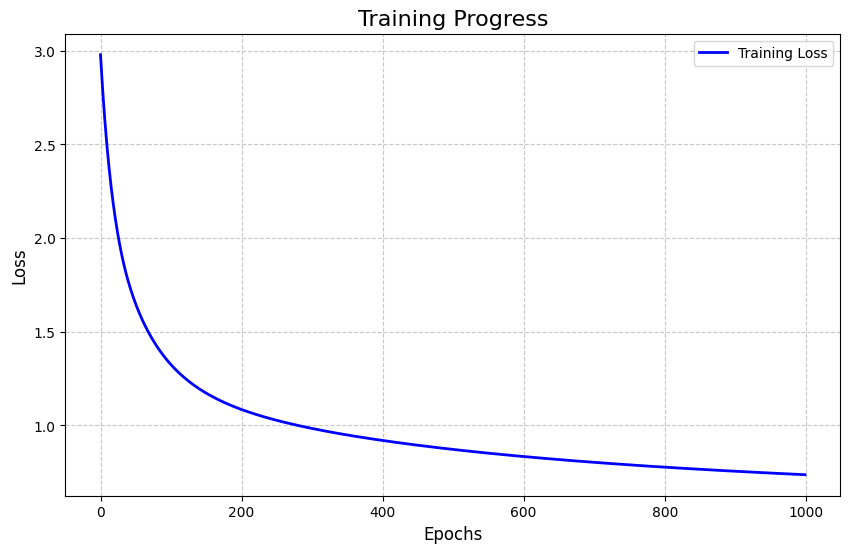

Test MSE: 0.7661
Test RMSE: 0.8753
Test R^2: 0.4154


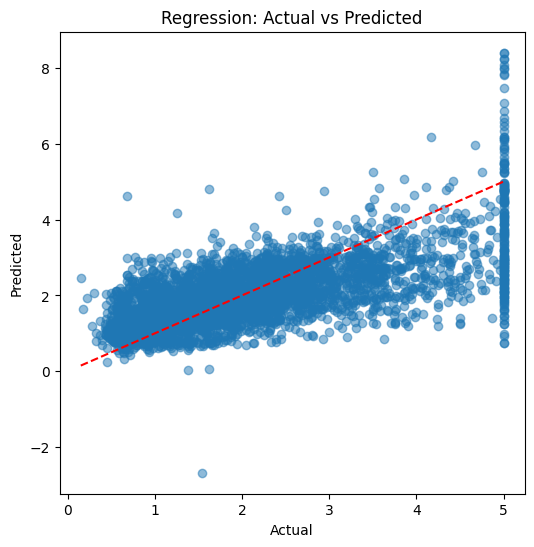

In [163]:
# Test between SiLU and ReLU
print('Testing ReLU MLP')
relu_mlp = [nn.Linear(in_features, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, out_features)]
sgd = optim.SGD(relu_mlp, learning_rate=1e-3)

loss_list = train(relu_mlp, X_train, y_train, sgd, criterion, num_epochs)
loss_plot(loss_list)
mse, rmse, r2 = test(relu_mlp, X_test, y_test, task='regression')

Testing SiLU MLP


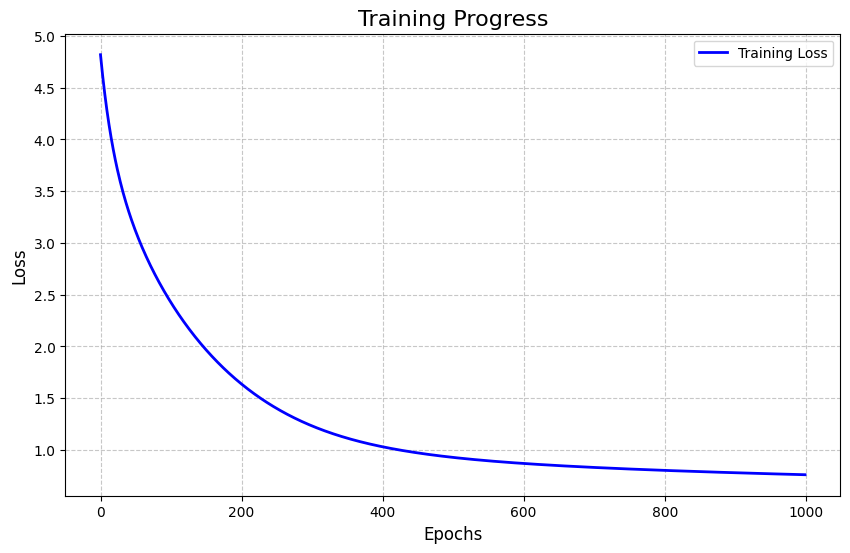

Test MSE: 0.7899
Test RMSE: 0.8888
Test R^2: 0.3972


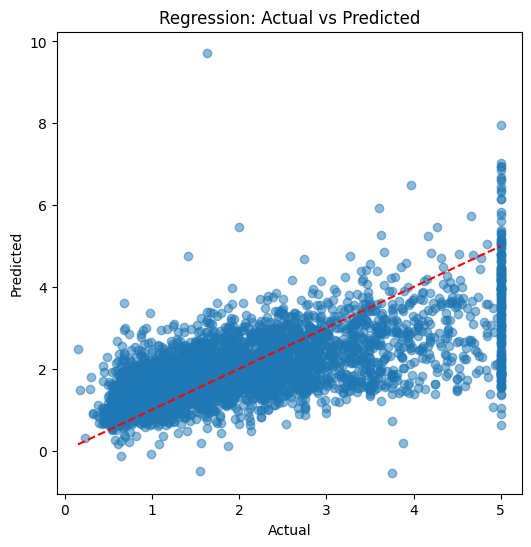

In [164]:
print('Testing SiLU MLP')
silu_mlp = [nn.Linear(in_features, 16), nn.SiLU(), nn.Linear(16, 16), nn.SiLU(), nn.Linear(16, out_features)]
sgd = optim.SGD(silu_mlp, learning_rate=1e-3)

loss_list = train(silu_mlp, X_train, y_train, sgd, criterion, num_epochs)
loss_plot(loss_list)
mse, rmse, r2 = test(silu_mlp, X_test, y_test, task='regression')

Based on these results, we see that the differences between ReLU and SiLU are negligible, with ReLU very slightly winning out. Now we test the ReLU MLP with the Adam optimizer.

Testing ReLU MLP


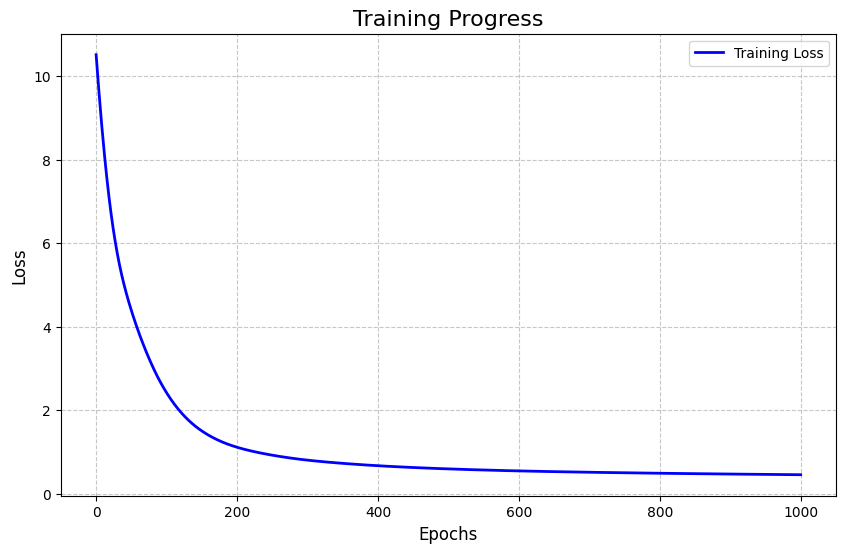

Test MSE: 0.4694
Test RMSE: 0.6852
Test R^2: 0.6418


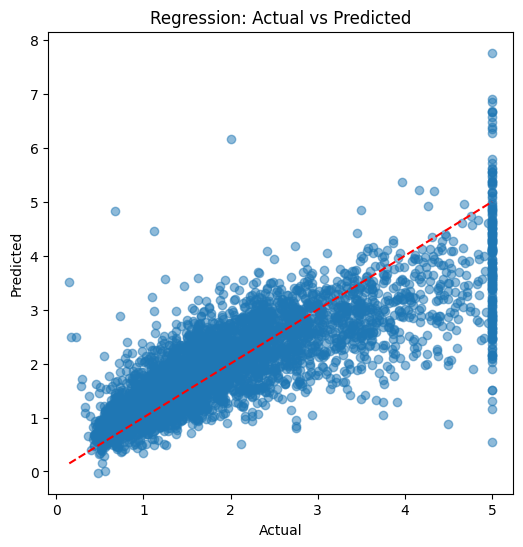

In [165]:
# Test ReLU with Adam
print('Testing ReLU MLP')
relu_mlp = [nn.Linear(in_features, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, out_features)]
sgd = optim.Adam(relu_mlp, learning_rate=1e-3)

loss_list = train(relu_mlp, X_train, y_train, sgd, criterion, num_epochs)
loss_plot(loss_list)
mse, rmse, r2 = test(relu_mlp, X_test, y_test, task='regression')

Based on these results, we see that Adam completely destroys SGD in terms of performance. The losses were much lower and the R^2 score was higher. Now we compare the ReLU Adam MLP with and without Dropout.

Testing ReLU MLP


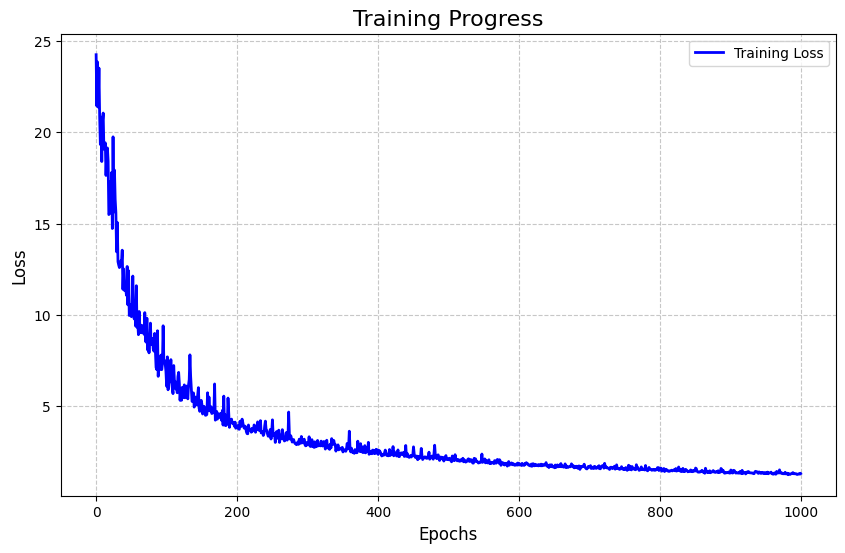

Test MSE: 0.6935
Test RMSE: 0.8328
Test R^2: 0.4707


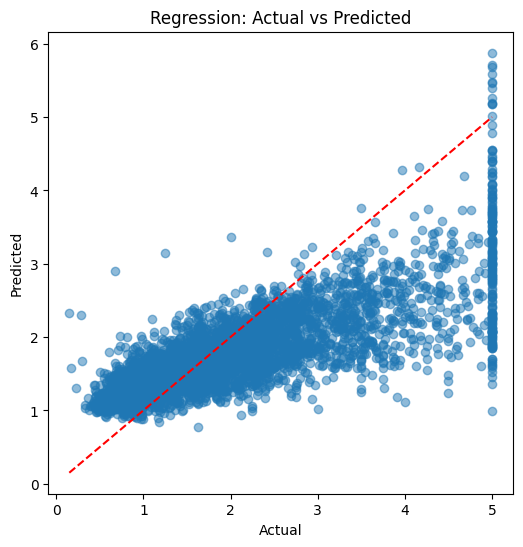

In [166]:
# Test ReLU with Adam and Dropout
print('Testing ReLU MLP')
relu_mlp_dropout = [nn.Linear(in_features, 16), nn.ReLU(), nn.Dropout(), nn.Linear(16, 16), nn.ReLU(), nn.Dropout(), nn.Linear(16, out_features)]
sgd = optim.Adam(relu_mlp_dropout, learning_rate=1e-3)

loss_list = train(relu_mlp_dropout, X_train, y_train, sgd, criterion, num_epochs)
loss_plot(loss_list)
mse, rmse, r2 = test(relu_mlp_dropout, X_test, y_test, task='regression')

We can see that Dropout did indeed have better loss performance and the R^2 accuracy was much better than the non-Adam MLP. This shows that Dropout is indeed acting as a regularizer and improving performance. Despite that, it did not beat the ReLU w/ Adam in the R^2 score. This is possibly due to the fact that dataset is small and simple.

I summarize the results in a table below.

| Metric | ReLU w/ SGD | SiLU w/ SGD | ReLU w/ Adam | ReLU w/ Adam & Dropout |
|--------|------------------|------------------|-------------------|-----------------------------|
| MSE  (Lower is better)  |          0.766        |        0.789        |         **0.469**         |      0.693           |
| RMSE (Lower is better)  |         0.875         |           0.888       |    **0.685**             |        0.832         |
| R^2   (Higher is better)  |          0.4156        |         0.397         |       **0.641**        |          0.470       |

## Classification Experiment
For classification I will do the same process as for regression. First we train a Sigmoid vs. Tanh model, take the better one and compare SGD vs. Adam, then add Dropout layers to see the performance.

The dataset used is CIFAR-10, which has 10 classes, 60,000 training samples, and 10,000 testing samples. We get the dataset from PyTorch, once again validating the compatability of Nabla with other AI frameworks.

In [168]:
from torchvision.transforms import v2
import torch
import warnings
warnings.filterwarnings('ignore')

# Get dataset and splits
transform = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True)
    ])
train_dataset = CIFAR10('./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10('./data', train=False, transform=transform, download=True)

classes = train_dataset.classes

scaler = StandardScaler()

num_train_samples = len(train_dataset)
in_features = train_dataset[0][0].reshape(-1).shape[0]
out_features = len(classes)
X_train = train_dataset.data
X_train = X_train.reshape(num_train_samples, in_features)
X_train = scaler.fit_transform(X_train)
y_train = np.array(train_dataset.targets)

num_test_samples = len(test_dataset)
X_test = test_dataset.data
X_test = X_test.reshape(num_test_samples, in_features)
X_test = scaler.transform(X_test)
y_test = np.array(test_dataset.targets)
print(X_test.shape)

criterion = nn.CrossEntropyLoss()
num_epochs = 1000

(10000, 3072)


Testing Sigmoid MLP


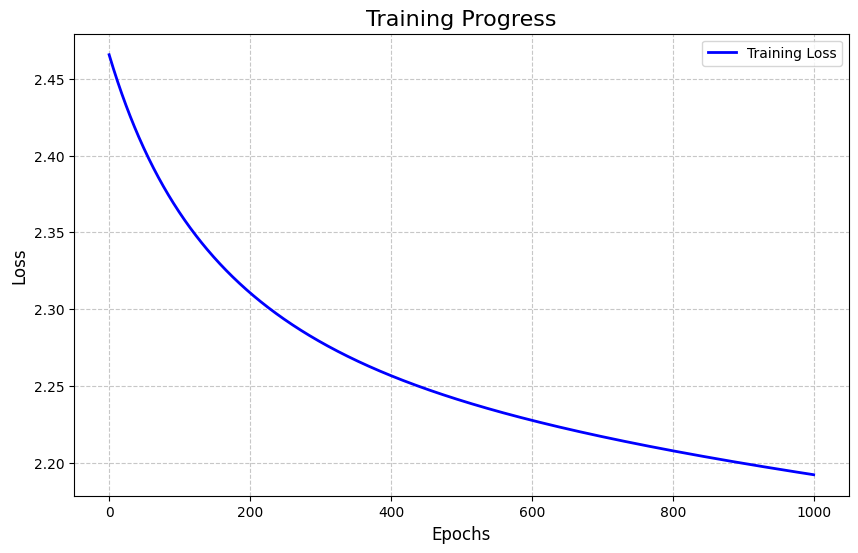

Test Accuracy: 20.80%
Test Precision: 18.51%
Test Recall: 20.80%
Test F1: 17.75%


In [173]:
# Test between Sigmoid and Tanh
print('Testing Sigmoid MLP')
sigmoid_mlp = [nn.Linear(in_features, 100), nn.Sigmoid(), nn.Linear(100, 100), nn.Sigmoid(), nn.Linear(100, out_features)]
sgd = optim.SGD(sigmoid_mlp, learning_rate=1e-3)
loss_list = train(sigmoid_mlp, X_train, y_train, sgd, criterion, num_epochs)
loss_plot(loss_list)
accuracy, precision, recall, f1 = test(sigmoid_mlp, X_test, y_test, task='classification', classes=classes)

Testing Tanh MLP


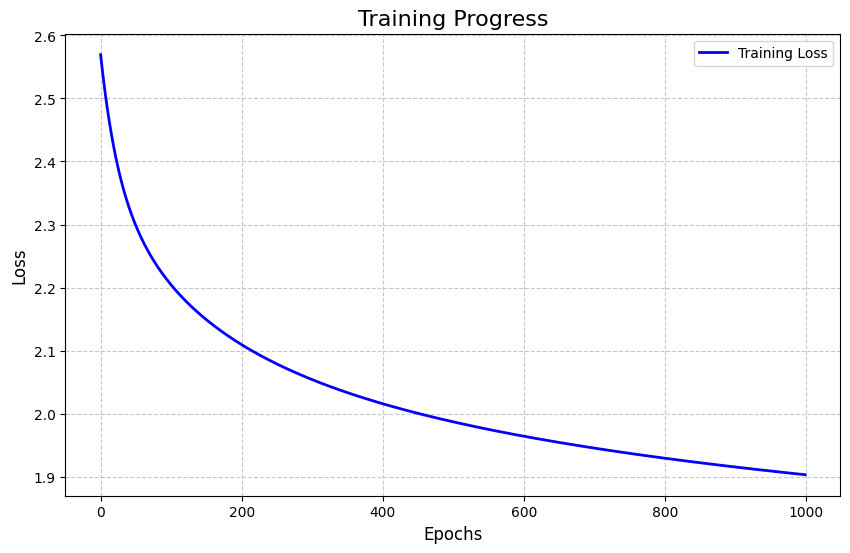

Test Accuracy: 31.67%
Test Precision: 30.61%
Test Recall: 31.67%
Test F1: 30.45%


In [174]:
print('Testing Tanh MLP')
tanh_mlp = [nn.Linear(in_features, 100), nn.Tanh(), nn.Linear(100, 100), nn.Tanh(), nn.Linear(100, out_features)]
sgd = optim.SGD(tanh_mlp, learning_rate=1e-3)
loss_list = train(tanh_mlp, X_train, y_train, sgd, criterion, num_epochs)
loss_plot(loss_list)
accuracy, precision, recall, f1 = test(tanh_mlp, X_test, y_test, task='classification', classes=classes)

Based on the results of Sigmoid vs. Tanh, we can see that Tanh is indeed vastly superior in every way. It beat Sigmoid in every metric. Now we compare vs an Adam variant.

Testing Tanh MLP w/ Adam


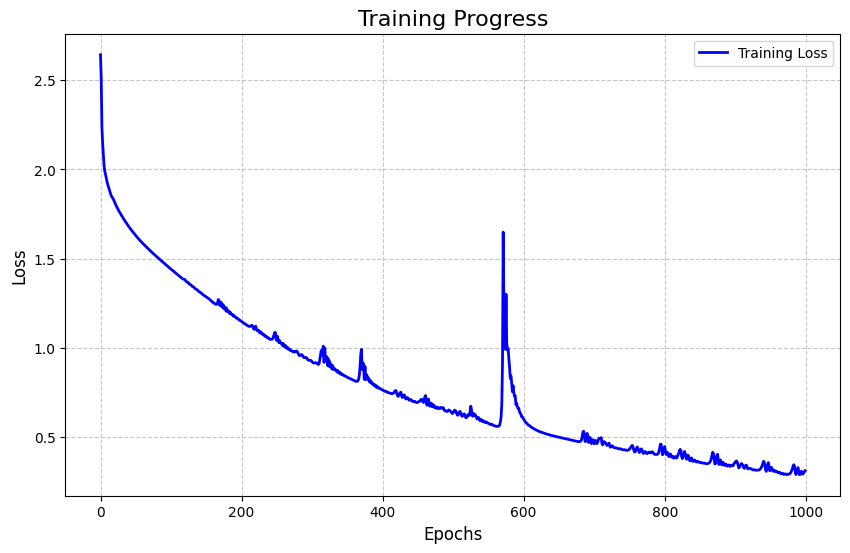

Test Accuracy: 37.85%
Test Precision: 38.15%
Test Recall: 37.85%
Test F1: 37.95%


In [175]:
print('Testing Tanh MLP w/ Adam')
tanh_mlp = [nn.Linear(in_features, 100), nn.Tanh(), nn.Linear(100, 100), nn.Tanh(), nn.Linear(100, out_features)]
sgd = optim.Adam(tanh_mlp, learning_rate=1e-3)
loss_list = train(tanh_mlp, X_train, y_train, sgd, criterion, num_epochs)
loss_plot(loss_list)
accuracy, precision, recall, f1 = test(tanh_mlp, X_test, y_test, task='classification', classes=classes)

Not surprisingly, Adam won again. It is interesting to see a spike in the loss graph, though. Now we test against the Dropout variant.

Testing Tanh MLP w/ Adam and Dropout


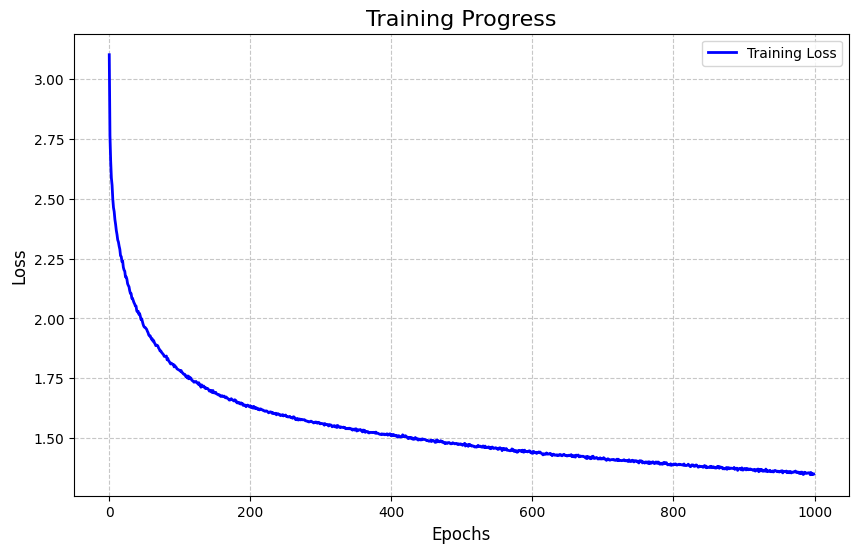

Test Accuracy: 47.38%
Test Precision: 47.19%
Test Recall: 47.38%
Test F1: 47.18%


In [176]:
print('Testing Tanh MLP w/ Adam and Dropout')
tanh_mlp = [nn.Linear(in_features, 100), nn.Tanh(), nn.Dropout(),  nn.Linear(100, 100), nn.Tanh(), nn.Dropout(), nn.Linear(100, out_features)]
sgd = optim.Adam(tanh_mlp, learning_rate=1e-3)
loss_list = train(tanh_mlp, X_train, y_train, sgd, criterion, num_epochs)
loss_plot(loss_list)
accuracy, precision, recall, f1 = test(tanh_mlp, X_test, y_test, task='classification', classes=classes)

Unlike the regression task, Dropout had a very positive effect here. It increased all metrics by at least 9%. This is due to the fact that the model and dataset were much bigger and only had 10 classification outputs. Rather than the model overfitting or putting too much weight on one class, it distributed the weights among them all, leading to better performance and generalization. 

I summarize the results in a table below.
Test Accuracy: 47.38%
Test Precision: 47.19%
Test Recall: 47.38%
Test F1: 47.18%

| Metric | Sigmoid w/ SGD | Tanh w/ SGD | Tanh w/ Adam | Tanh w/ Adam & Dropout |
|--------|------------------|------------------|-------------------|-----------------------------|
| Accuracy  (Higher is better)  |   20.80%   |   31.67%  |  37.85% |      **47.38%**     |
| Precision (Higher is better)  |  18.51%    |   30.61%  |   38.15%   |     **47.19%**     |
| Recall   (Higher is better)  |   20.80%     |   31.67%     |   37.85% |      **47.38%**     |
| F1   (Higher is better)  |    17.75%    |    30.45%    |  37.95%  |     **47.18%**     |

## Conclusion
I have shown how to use the Nabla neural network library. In this demo, I showed how to load datasets, instantiate models, train them, and test them. I showed empirical experimental results as well. I hope you enjoyed reading and using the library! Thank you!